In [1]:
%reload_ext autoreload
%autoreload 2
import csv
from CIOGame import *
import pandas as pd
import numpy as np
from sklearn import linear_model, preprocessing, ensemble
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from gurobipy import *

# CIO regression
## Read data sets from .xlsm

In [21]:
cio_game=CIOGame(5)
df_cmo=cio_game.read_from_exel().T
df_cmo

Created CIOGame Object for period 5


,Car Financing Loans,Customer Savings,Requests to be processed LowPriceCars,Requests to be processed MidPriceCars,Requests to be processed HighPriceCars,Contracts succeeded LowPriceCars,Contracts succeeded MidPriceCars,Contracts succeeded HighPriceCars,Service Transactions to be processed loans,Service Transactions succeeded loans,...,Service Transactions to be processed savings,Service Transactions succeeded savings,Customer Satisfaction,Marketing Efficiency for product Car Financing Loans,Marketing Efficiency for product Savings Account,Marketing Expenditures Global,Marketing Expenditures Product Loans,Marketing Expenditures Product Savings,Interest Rate Car Financing Loans,Interest Rate Customer Savings
0,1.806205e+09,1.084270e+09,59391.8,74239.8,14848.0,18460.7,23075.9,4615.2,216749.4,173290.4,...,162640.8,156517.6,0.8332,0.7295,0.6915,4500000.0,2220000.0,1200000.0,0.120,0.030
1,2.595910e+09,9.625200e+08,56685.5,70856.9,14171.4,39239.7,49049.6,9809.9,311509.6,298465.7,...,144377.4,135516.1,0.8492,0.6938,0.6576,4500000.0,2020000.0,1400000.0,0.120,0.035
2,3.387190e+09,1.138230e+09,62877.9,78597.4,15719.5,41754.9,52193.6,10438.7,406463.3,327376.3,...,170734.6,162806.6,0.8681,0.7884,0.7680,4500000.0,2220000.0,1200000.0,0.123,0.035
3,3.732180e+09,2.021880e+09,46496.4,58120.5,11624.1,35495.5,44369.4,8873.9,447862.1,425422.3,...,303281.3,285108.1,0.8929,0.9085,0.9026,3300000.0,1100000.0,900000.0,0.130,0.032
4,4.475400e+09,3.038280e+09,54842.7,68553.3,13710.7,50091.1,62613.9,12522.8,537047.4,524852.8,...,455742.2,428042.9,0.9269,0.9689,0.9684,3600000.0,1200000.0,1440000.0,0.137,0.030
5,5.574000e+09,5.433580e+09,63389.0,5.0,15847.3,60304.8,75381.0,15076.2,668880.0,651918.1,...,815036.6,668233.4,0.9663,0.9854,0.9854,4500000.0,1500000.0,5000000.0,0.147,0.023


In [22]:
df_cmo.keys()

Index(['Car Financing Loans', 'Customer Savings',
       'Requests to be processed LowPriceCars',
       'Requests to be processed MidPriceCars',
       'Requests to be processed HighPriceCars',
       'Contracts succeeded LowPriceCars', 'Contracts succeeded MidPriceCars',
       'Contracts succeeded HighPriceCars',
       'Service Transactions to be processed loans',
       'Service Transactions succeeded loans',
       'Requests to be processed savings', 'Contracts succeeded savings',
       'Service Transactions to be processed savings',
       'Service Transactions succeeded savings', 'Customer Satisfaction',
       'Marketing Efficiency for product Car Financing Loans',
       'Marketing Efficiency for product Savings Account',
       'Marketing Expenditures Global', 'Marketing Expenditures Product Loans',
       'Marketing Expenditures Product Savings',
       'Interest Rate Car Financing Loans', 'Interest Rate Customer Savings'],
      dtype='object', name='')

In [23]:
df_cmo=df_cmo.drop(["Customer Savings","Requests to be processed LowPriceCars","Requests to be processed HighPriceCars","Contracts succeeded LowPriceCars","Contracts succeeded HighPriceCars","Requests to be processed savings","Contracts succeeded savings","Service Transactions to be processed savings","Service Transactions succeeded savings","Marketing Efficiency for product Savings Account","Marketing Expenditures Product Savings","Interest Rate Customer Savings","Requests to be processed MidPriceCars","Service Transactions to be processed loans","Customer Satisfaction"],axis=1)

In [24]:
df_cmo

,Car Financing Loans,Contracts succeeded MidPriceCars,Service Transactions succeeded loans,Marketing Efficiency for product Car Financing Loans,Marketing Expenditures Global,Marketing Expenditures Product Loans,Interest Rate Car Financing Loans
0,1.806205e+09,23075.9,173290.4,0.7295,4500000.0,2220000.0,0.120
1,2.595910e+09,49049.6,298465.7,0.6938,4500000.0,2020000.0,0.120
2,3.387190e+09,52193.6,327376.3,0.7884,4500000.0,2220000.0,0.123
3,3.732180e+09,44369.4,425422.3,0.9085,3300000.0,1100000.0,0.130
4,4.475400e+09,62613.9,524852.8,0.9689,3600000.0,1200000.0,0.137
5,5.574000e+09,75381.0,651918.1,0.9854,4500000.0,1500000.0,0.147


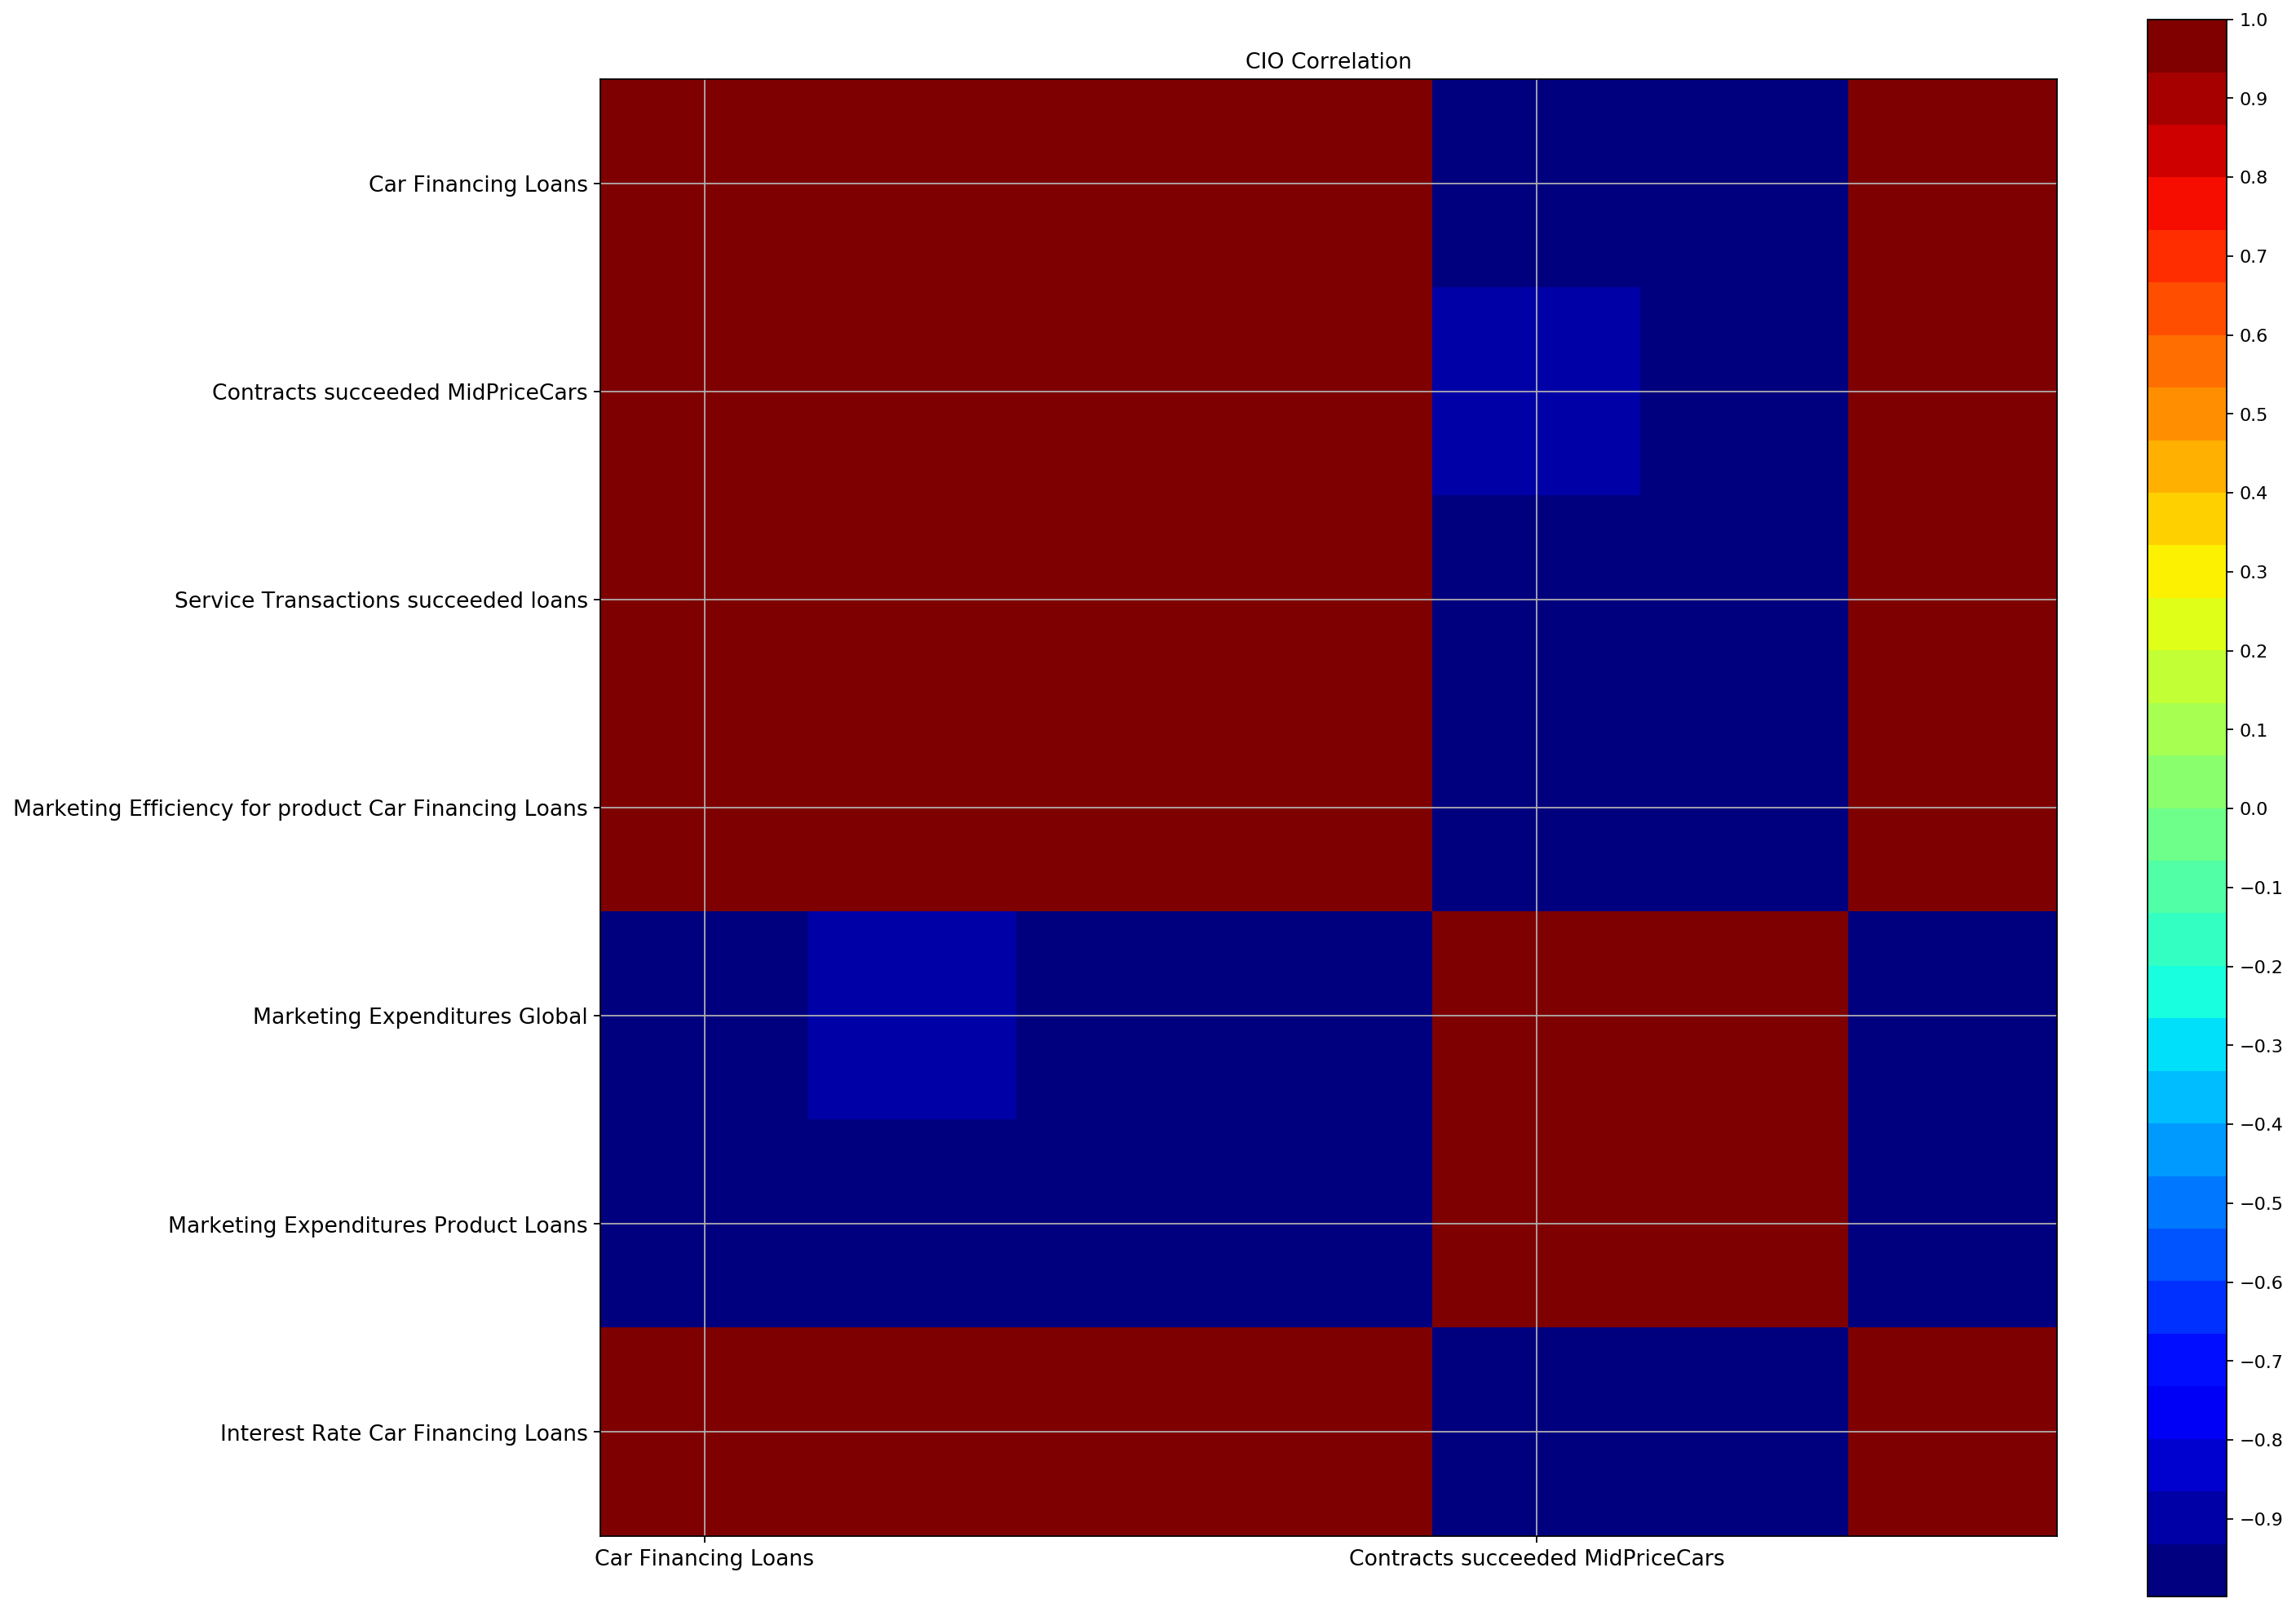

In [25]:
cio_game.correlation_matrix(df_cmo.corr())

In [ ]:
sum_contracts_succeeded_loans=df_cmo[[
    'Contracts succeeded LowPriceCars',
    'Contracts succeeded MidPriceCars',
    'Contracts succeeded HighPriceCars'
]].sum(axis=1).rename("Contracts succeeded Total")

df_loans=df_cmo[[
    "Car Financing Loans",
    'Service Transactions succeeded loans',
]]
df_loans=df_loans.T.append(sum_contracts_succeeded_loans).T

## Find the best regression model

In [ ]:
y=df_loans["Car Financing Loans"]
X=df_loans.drop(["Car Financing Loans"],axis=1)
regr_loans=cio_game.find_best_regr(X[:-1],y[:-1],X.iloc[len(X)-1],y.iloc[len(y)-1])

## Find the relationship of amount contracts in last period and amount of service transactions in this period

In [ ]:
df_ta_loans=df_loans.drop(["Car Financing Loans"],axis=1).T.append(df_cmo["Service Transactions to be processed loans"].shift(-1).rename("Service Transactions to be processed loans next Period"))
df_ta_loans=df_ta_loans.append(df_cmo["Service Transactions succeeded loans"].shift(1).rename("Service Transactions succeeded loans last Period")).T
y=df_ta_loans["Service Transactions to be processed loans next Period"][1:]
X=df_ta_loans.drop(["Service Transactions to be processed loans next Period"],axis=1)[1:]
regr_ta_loans=cio_game.find_best_regr(X[:-1],y[:-1],X.iloc[len(X)-1],y.iloc[len(y)-1])

In [ ]:
Service_Transactions_to_be_processed_loans_next_Period=813679.61353
Service_Transactions_succeeded_loans_last_Period=651918.1
for new_loans in range(150000,700000,50000):
    X_test=pd.Series({
        "Service Transactions succeeded loans":Service_Transactions_to_be_processed_loans_next_Period,
             "Contracts succeeded Total":new_loans,
             "Service Transactions succeeded loans last Period":Service_Transactions_succeeded_loans_last_Period})
    loans_pre=regr_loans.predict([Service_Transactions_to_be_processed_loans_next_Period,new_loans])
    #if loans_pre>=8000000000:
    print("%g: %g"%(new_loans,loans_pre))

## need 500000 loans TAs 

In [ ]:
X=df_cmo[[
    'Marketing Efficiency for product Car Financing Loans',
    'Marketing Expenditures Global', 
    'Marketing Expenditures Product Loans',
    #'Interest Rate Car Financing Loans'
]]
y=df_cmo[[
    'Requests to be processed LowPriceCars',
    'Requests to be processed MidPriceCars',
    'Requests to be processed HighPriceCars'
]].sum(axis=1).rename("Requests to be processed Total")

In [ ]:
regr_exp_loans=cio_game.find_best_regr(X[:-1],y[:-1],X.loc[5],y.loc[5])

# Savings

In [ ]:
df_cmo.keys()

In [ ]:
df_savings=df_cmo[[
    "Customer Savings",
    'Contracts succeeded savings',
    'Service Transactions succeeded savings'
]]
df_savings

In [ ]:
y=df_savings["Customer Savings"]
X=df_savings.drop(["Customer Savings"],axis=1)
regr_savings=cio_game.find_best_regr(X[:-1],y[:-1],X.loc[5],y.loc[5])

## Service is more importent

In [ ]:
df_ta_savings=df_savings.drop(["Customer Savings"],axis=1).T.append(df_cmo["Service Transactions to be processed savings"].shift(-1).rename("Service Transactions to be processed savings next Period"))
df_ta_savings=df_ta_savings.append(df_cmo["Service Transactions succeeded savings"].shift(1).rename("Service Transactions succeeded savings last Period")).T
y=df_ta_savings["Service Transactions to be processed savings next Period"][1:]
X=df_ta_savings.drop(["Service Transactions to be processed savings next Period"],axis=1)[1:]
regr_ta_savings=cio_game.find_best_regr(X[:-1],y[:-1],X.iloc[len(X)-1],y.iloc[len(y)-1])

In [ ]:
df_ta_savings

In [ ]:
Service_Transactions_to_be_processed_savings_next_Period=1466423.24041
for new_savings in range(1000000,4000000,500000):
    savings_pre=regr_savings.predict([Service_Transactions_to_be_processed_savings_next_Period,new_savings])
    if savings_pre>=8000000000:
        print("%g: %g"%(new_savings,savings_pre))

In [ ]:
cio_game.find_best_solution(regr_exp_loans,best_regr_savings,450000,500000)

# test

In [29]:
global_expenditure=np.array([4500000,4500000,4500000,3300000,3600000,4500000,10000000])

savings_intrests_rate=np.array([0.0300,0.0350,0.0350,0.0320,0.03,0.023,0.02])
savings_expenditure=np.array([1200000,1400000,1200000,900000,1440000,5000000,5500000])
savings_marketing_efficiency=np.array([0.6915,0.6576,0.7680,0.9026,0.9684,0.9864,0.9897])

loans_intrests_rate=np.array([0.12,0.12,0.123,0.13,0.137,0.147,0.15])
loans_expenditure=np.array([2220000,2020000,2220000,1100000,1200000,1500000,2000000])
loans_marketing_efficiency=np.array([0.7295,0.6938,0.7884,0.9085,0.9689,0.9854,0.9897])

savings_requests=np.array([902795.10,951090.40,993601.10,837795.40,1114117.8,2376077.1,6112762.2 ])
loans_requests=np.array([148479.60,141713.80 ,157194.80 ,116241.00,137106.70,158472.6,235070.8])
#loans_requests=np.array([74239.80 ,70856.90 ,78597.40 ,58120.50 ,68553.30 ,79236.3])

df_savings=pd.DataFrame({
    "global_expenditure":global_expenditure,
    "savings_expenditure":savings_expenditure,
    "savings_intrests_rate":savings_intrests_rate,
    "savings_marketing_efficiency":savings_marketing_efficiency,
    "savings_requests":savings_requests})
df_loans=pd.DataFrame({
    "global_expenditure":global_expenditure,
    "loans_expenditure":loans_expenditure,
    "loans_intrests_rate":loans_intrests_rate,
    "loans_marketing_efficiency":loans_marketing_efficiency,
    "loans_requests":loans_requests})

In [30]:
df_savings

,global_expenditure,savings_expenditure,savings_intrests_rate,savings_marketing_efficiency,savings_requests
0,4500000,1200000,0.030,0.6915,902795.1
1,4500000,1400000,0.035,0.6576,951090.4
2,4500000,1200000,0.035,0.7680,993601.1
3,3300000,900000,0.032,0.9026,837795.4
4,3600000,1440000,0.030,0.9684,1114117.8
5,4500000,5000000,0.023,0.9864,2376077.1
6,10000000,5500000,0.020,0.9897,6112762.2


In [31]:
df_loans["global_expenditure"]

0     4500000
1     4500000
2     4500000
3     3300000
4     3600000
5     4500000
6    10000000
Name: global_expenditure, dtype: int64

In [35]:
y_savings=df_savings["savings_requests"]
X_savings=df_savings.drop(["savings_requests"],axis=1)

df_savings_pre=pd.DataFrame({
    "global_expenditure":[10000000],
    "savings_expenditure":[5500000],
    "savings_intrests_rate":[0.02],
    "savings_marketing_efficiency":[0.9897]
})

best_regr_savings=cio_game.find_best_regr(X_savings,y_savings,df_savings_pre,6600000)

[0.99330646210973428, 0.2783597308592336, 0.27798950207029116, 0.28526540417525803, 0.11737477256358253, 0.41636999396603147, 0.45048464504466301]
6600000
6095945.77523
                       features  estimatedCoefficients
0            global_expenditure           6.546495e-01
1           savings_expenditure           1.240328e-01
2         savings_intrests_rate          -9.222614e+06
3  savings_marketing_efficiency           3.075215e+06


In [28]:
y_loans=df_loans["loans_requests"]
X_loans=df_loans.drop(["loans_requests"],axis=1)

df_loans_pre=pd.DataFrame({
    "global_expenditure":[10000000],
    "savings_expenditure":[2000000],
    "savings_intrests_rate":[0.15],
    "savings_marketing_efficiency":[0.9897]
})

best_regr_loans=cio_game.find_best_regr(X_loans,y_loans,df_loans_pre,158472.6)

[0.018867839435991796, 0.072902637381878854, 0.010878137992754167, 0.069404556240113102, 0.042357230475284946, 0.11588187408826101, 0.84735249034260063]
158472.6
235078.144459
                     features  estimatedCoefficients
0          global_expenditure               0.010351
1           loans_expenditure               0.032928
2         loans_intrests_rate          564804.478680
3  loans_marketing_efficiency           72808.496396


In [20]:
best_regr_savings.coef_

array([  1.60593161e-01,   3.40282862e-01,   1.51312970e+07,
         1.10626159e+06])

In [21]:
best_regr_loans.coef_

array([  1.03511845e-02,   3.29284319e-02,   5.64804479e+05,
         7.28084964e+04])

# Note

## CIO
- WP055/WP056 

## COO
- Utilization

## CMO
- regression
- customer lose ratio

## CFO

## PMO
- Marketingprojects 13,46/16,40/14,15


Some groups are doing the quantitative research like building a model by using the regression to describe the relationship between marketing expenditure and the requests so we can set an expected amount of savings or loans as input and know how much we should spend to grow the market share. What do you think about the meaning and the correctness of their job?

I think your advice is constructive for me. You find some helpful points which we neglected in the previous periods. And yes I'll consider it to make the CMO strategy in the next phase. My question is an open question, so I am not expecting a "right" answer, but yours is obviously reasonable and well-founded. So thank again for your outstanding presentation and explanation.

global: 7 Mill.
loans: 10 Mill.

In [3]:
1000000/0.15

6666666.666666667

In [4]:
15/14

1.0714285714285714

In [6]:
37/(20/45/0.5967)

49.675275